Reagent Data Notebook
====================

Purpose
------------
* This notebook is aimed at visualising trade flows of reagents 
* Data is to support ongoing work at [Reclone](https://reclone.org/)


Data Source
------------------
* This data is gathered from the [UN Comtrade Database](https://comtrade.un.org/)
* Data is gathered via the UN Comtrade [Data Request API](https://comtrade.un.org/data/doc/api/#DataRequests) 
* Data is gathered using classification code: HS382200 

Figures
--------
1. Import/Export of Reagents by Country in USD - 2019
    * all countries, not sorted 
2. Export of Reagents by Country in USD - 2019 
    * all countries, sorted (descending) 







In [35]:
import requests
import matplotlib.pyplot as plt
import numpy as np

def get_data(year):
    ''' returns dataset in json converted to python format '''
    base = 'http://comtrade.un.org/api/get?' # base api, documentation : https://comtrade.un.org/data/doc/api/#DataRequests
    payload = {'type' : 'C', 'freq' : 'A', 'px': 'HS', 'ps' : year, 'r': 'all', 'p' : '0', 'cc' : '382200', 'rg': 'all' } # params, note ps = year. cc = comoditity code

    r = requests.get(base, params=payload)
    jason = r.json()
    dataset = jason['dataset'] # dataset of api

    return dataset # list of dictionaries

def extract_data(dataset):
    ''' Takes json from get_data() and returns list of dictionaries for entries in form [{Country: , Flow: , Value:, Quantity:}, {}]'''

    trade = [] # holds a list of dictionaries where each dic is an entry in dataset holding {Country: , Flow: , Value:, Quantity:  }

    for entry in dataset:

        entry_dic = {}
        country = entry['rtTitle'] # country name
        trade_flow = entry['rgDesc'] # import, export, re-import, re-export
        trade_value = entry['TradeValue'] # value in usd
        trade_qnt = entry['TradeQuantity'] # units =  (kg)

        # creates dictionary
        entry_dic['Country'] = country
        entry_dic['Flow'] = trade_flow
        entry_dic['Value'] = trade_value
        entry_dic['Quantity'] = trade_qnt

        trade.append(entry_dic)

    return trade

def balance_data(extracted_data):
    ''' Takes a list of dics of unbalanced extracted data from extract_data(), returns list of dics of balanced country export/import data for value and qnt '''

    extracted_data = extracted_data # make local version as dont want to update global version

    balanced_list = [] # holds dictionaries of balanced countries

    for entry in extracted_data:

        country = entry['Country']

        if country != 'Checked': # make sure entry has not already been evaluated

            balanced_dic = {} # makes dictionary {Country: , Net_Import_Value: , Net_Export_Value: , Net_Import_Quantity: , Net_Export_Quantity: , }

            net_import_value = 0
            net_export_value = 0

            net_import_qnt = 0
            net_export_qnt = 0

            for entry in extracted_data: # Balances Countries import/export data for re-imports/re-exports

                if entry['Country'] == country: # checks to see if entry is same country

                    if entry['Flow'] == 'Import':
                        net_import_value += entry['Value']
                        net_import_qnt += entry['Quantity']
                    if entry['Flow'] == 'Re-Export':
                        net_import_value -= entry['Value']
                        net_import_qnt -= entry['Quantity']

                    if entry['Flow'] == 'Export':
                        net_export_value += entry['Value']
                        net_export_qnt += entry['Quantity']
                    if entry['Flow'] == 'Re-Import':
                        net_export_value -= entry['Value']
                        net_export_qnt -= entry['Quantity']

                    entry['Country'] = 'Checked' # Need to change country name so doesn't loop doesnt repeat for every entry

            balanced_dic['Country'] = country
            balanced_dic['Net_Import_Value'] = net_import_value
            balanced_dic['Net_Export_Value'] = net_export_value
            balanced_dic['Net_Import_Quantity'] = net_import_qnt
            balanced_dic['Net_Export_Quantity'] = net_export_qnt

            balanced_list.append(balanced_dic)

    return balanced_list

def graph_format(balanced_data):
    ''' Takes list of dics from balance_data and returns lists for categories when index is constant per country. countries, value_import, value_export, qnt_import, qnt_export '''
    countries = []
    value_import = []
    value_export = []
    qnt_import = []
    qnt_export = []

    for entry in balanced_data:
        countries.append(entry['Country'])
        value_import.append(entry['Net_Import_Value'])
        value_export.append(entry['Net_Export_Value'])
        qnt_import.append(entry['Net_Import_Quantity'])
        qnt_export.append(entry['Net_Export_Quantity'])

    return countries, value_import, value_export, qnt_import, qnt_export

In [36]:
def main_2019():

    # Data Wrangling
    dataset = get_data(2019)
    extracted_data = extract_data(dataset)
    balanced_data = balance_data(extracted_data)
    graphing_data = graph_format(balanced_data)

    # Retrieving graphing data
    Countries = graphing_data[0]
    value_import = graphing_data[1]
    value_export = graphing_data[2]
    qnt_import = graphing_data[3]
    qnt_export = graphing_data[4]

    return graphing_data

graphing_data_2019 = main()

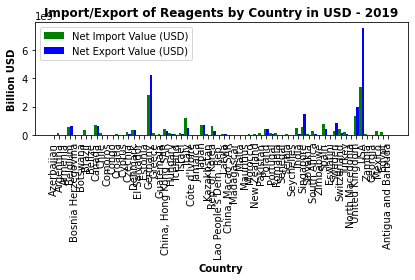

In [37]:
%matplotlib inline

countries = graphing_data_2019[0]
divisions = countries
imports = graphing_data_2019[1]
exports = graphing_data_2019[2]

index = np.arange(len(divisions))
width = 0.50

plt.bar(index, imports, width, color='green', label='Net Import Value (USD)')
plt.bar(index+width, exports, width, color='blue', label='Net Export Value (USD)')
plt.title('Import/Export of Reagents by Country in USD - 2019', fontweight='bold')

plt.ylabel('Billion USD', fontweight = 'bold')
plt.xlabel('Country', fontweight = 'bold')
plt.xticks(index + width/2, countries, rotation='vertical') # ticks to divide import / export
plt.legend(loc='best')

plt.tight_layout()
plt.show()



*Figure 1: Import/Export of Reagents by Country in USD - 2019*
-------------------------------------------------------------------------------------------
**Notes:** 
* All countries available, not sorted 
* Import and Export data is taken as net
    * Net Import = Import - ReExport 
    * Net Export = Export - ReImport 
* ReExport/Import may refer to travel of reagents through country 


In [38]:
def Descending_export(graphing_data):
    '''Input = graphing data format from main,  Returns 2 paired lists countries and desc_export for exporting value '''
    countries = graphing_data[0]
    value_import = graphing_data[1]
    value_export = graphing_data[2]
    qnt_import = graphing_data[3]
    qnt_export = graphing_data[4]
    
    desc_dic = {} # dic of country : export value
    
    for country, value in zip(countries, value_export):
        desc_dic[country] = value
    
    desc_list = sorted(desc_dic.items(), key=lambda x: x[1], reverse=True) # creates list of tuples ([(Country, Export_value)])
    desc_country = []
    desc_export = []
    
    for tuple in desc_list: # Re-distributes to seperate lists but still linked 
        desc_country.append(tuple[0])
        desc_export.append(tuple[1])
        
    return desc_country, desc_export 
    

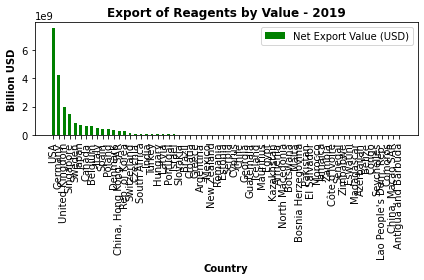

In [51]:
%matplotlib inline
graphing_data_desc = Descending_export(graphing_data_2019)

desc_countries = graphing_data_desc[0]
desc_export = graphing_data_desc[1]

index = np.arange(len(desc_countries))
width = 0.50

plt.bar(index, desc_export, width, color='green', label='Net Export Value (USD)')
plt.title('Export of Reagents by Value - 2019', fontweight='bold')

plt.ylabel('Billion USD', fontweight = 'bold')
plt.xlabel('Country', fontweight = 'bold')
plt.xticks(index, desc_countries, rotation='vertical') 
plt.legend(loc='best')

plt.tight_layout()
plt.show()


*Figure 2: Export of Reagents by Country in USD - 2019*
-------------------------------------------------------------------------------------------
**Notes:** 
* All countries available, sorted (descending) 
* Import and Export data is taken as net
    * Net Import = Import - ReExport 
    * Net Export = Export - ReImport 

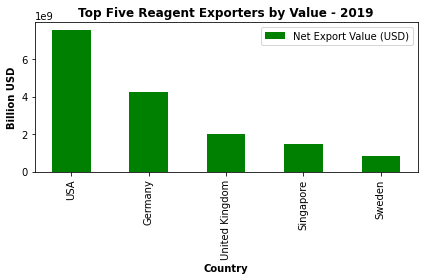

In [50]:
%matplotlib inline
graphing_data_desc = Descending_export(graphing_data_2019)

desc_countries = graphing_data_desc[0]
top_countries = desc_countries[0:5]

desc_export = graphing_data_desc[1]
top_export_values = desc_export[0:5]

index = np.arange(len(top_countries))
width = 0.50

plt.bar(index, top_export_values, width, color='green', label='Net Export Value (USD)')
plt.title('Top Five Reagent Exporters by Value - 2019', fontweight='bold')

plt.ylabel('Billion USD', fontweight = 'bold')
plt.xlabel('Country', fontweight = 'bold')
plt.xticks(index, top_countries, rotation='vertical') 
plt.legend(loc='best')

plt.tight_layout()
plt.show()

*Figure 3: Top Five Reagent Exporters by Value - 2019*
-------------------------------------------------------------------------------------------
**Notes:** 
* Top 5 Countries for export value, sorted (descending) 
* Import and Export data is taken as net
    * Net Import = Import - ReExport 
    * Net Export = Export - ReImport 

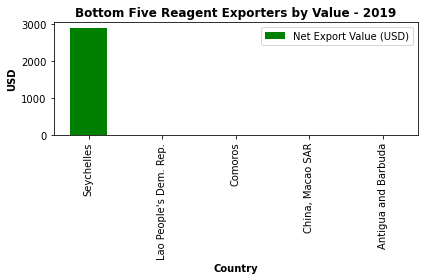

In [53]:
%matplotlib inline
graphing_data_desc = Descending_export(graphing_data_2019)

desc_countries = graphing_data_desc[0]
bottom_countries = desc_countries[-5:]

desc_export = graphing_data_desc[1]
bottom_export_values = desc_export[-5:]

index = np.arange(len(bottom_countries))
width = 0.50

plt.bar(index, bottom_export_values, width, color='green', label='Net Export Value (USD)')
plt.title('Bottom Five Reagent Exporters by Value - 2019', fontweight='bold')

plt.ylabel('USD', fontweight = 'bold')
plt.xlabel('Country', fontweight = 'bold')
plt.xticks(index, bottom_countries, rotation='vertical') 
plt.legend(loc='best')

plt.tight_layout()
plt.show()

*Figure 4: Bottom Reagent Exporters by Value - 2019*
-------------------------------------------------------------------------------------------
**Notes:** 
* Bottom 5 Countries for export value, sorted (descending) 
* Import and Export data is taken as net 
    * Net Export = Export - ReImport
* Perhaps a comparison of top versus bottom would be appropriate to give scale
* Important to note - not all countries are present